# 3D Visualization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes

import IPython

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

import plotly.graph_objects as go

#%matplotlib ipympl

In [2]:
dataset = pd.read_csv('kindle_data-v2.csv')

df = dataset.drop(['asin', 'imgUrl', 'productURL', 'category_id'], axis=1)
df.publishedDate = pd.to_datetime(dataset.publishedDate)

X = df.drop(['title', 'author', 'soldBy'], axis=1).copy()
X['soldByAmazon'] = df.soldBy.str.contains('Amazon')
X

,stars,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,soldByAmazon
0,4.8,0,9.99,False,True,False,False,2015-06-01,Parenting & Relationships,True
1,4.4,0,16.99,False,False,False,False,2022-02-15,Parenting & Relationships,False
2,4.8,0,16.99,False,False,True,False,2022-09-13,Parenting & Relationships,False
3,4.2,0,9.95,True,False,True,False,2020-02-25,Parenting & Relationships,False
4,4.7,0,13.99,False,False,False,False,2015-05-05,Parenting & Relationships,False
...,...,...,...,...,...,...,...,...,...,...
133097,4.7,0,0.00,False,True,False,False,2023-09-15,Nonfiction,False
133098,4.4,0,9.99,False,False,False,False,2021-09-30,Nonfiction,True
133099,4.8,0,1.99,False,True,False,False,2023-09-15,Nonfiction,False
133100,4.7,0,0.00,False,True,False,False,2023-08-25,Nonfiction,False


## Setup

In [3]:
def echo(df):
    print(df)
    return df
EchoTransformer = FunctionTransformer(echo)

def custom_date_transform(df):
    out = pd.DataFrame()
    for col in df.columns:
        out[col] = df[col].dt.year + ((df[col].dt.month-1)/12)
    return out
CustomDateTransformer = FunctionTransformer(custom_date_transform)

def zero_to_na_transform(df):
    return df[['price', 'reviews']].replace(0, np.nan)
ZeroToNaTransformer = FunctionTransformer(zero_to_na_transform)

def wrap_model(scaler=StandardScaler, encoder=lambda:OneHotEncoder(sparse_output=False), imputer=lambda:SimpleImputer(strategy="median"), transformers=[], poly=False):
    def inner(model):
        return make_pipeline(
            *transformers,
            make_column_transformer(
                (
                    make_pipeline(
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include=[np.number, bool])
                ),
                (
                    make_pipeline(
                        CustomDateTransformer,
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include='datetime')
                ),
                (encoder(), make_column_selector(dtype_include=object)),
            ), 
            *([PolynomialFeatures(2, interaction_only=True)] if poly else []), 
            model
        )
    return inner

def pt_pipeline():
    return make_pipeline(
        StandardScaler(),
        PowerTransformer()
    )

def scatter3D(df,x,y,z,hue):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    for h in np.unique(hue):
        gdf = df[hue==h]
        ax1.scatter(gdf[x],gdf[y],gdf[z],label=h)
        ax1.set_xlabel(x)
        ax1.set_ylabel(y)
        ax1.set_zlabel(z)
    """
    ax2 = fig.add_subplot(122)
    for h in np.unique(hue):
        gdf = df[hue==h]
        plt.scatter(gdf[x],gdf[y],label=h)
    """
    return ax1

def cluster_visualize(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    km = preprocess(cluster).fit(X)
    groups = km[-1].labels_
    
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')

def cluster_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    return groups

def cluster_visualize_on_pca(X, cluster=KMeans(n_clusters=5, n_init='auto'), pca_dims=2, preprocess=wrap_model()):
    pca = preprocess(PCA(n_components=pca_dims)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))

    km = preprocess(cluster).fit(pca_out)
    groups = km[-1].labels_
    
    if pca_dims == 3:
        return scatter3D(pca_out, x=0, y=1, z=2, hue=groups)
    else:
        return sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')


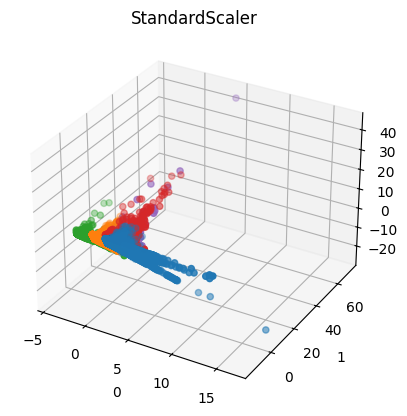

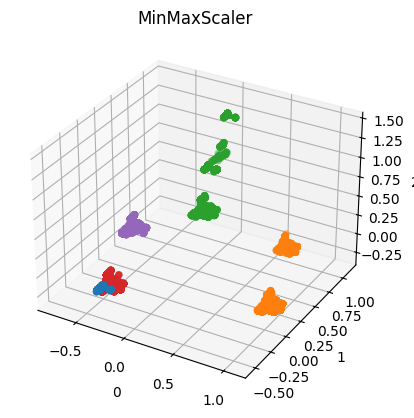

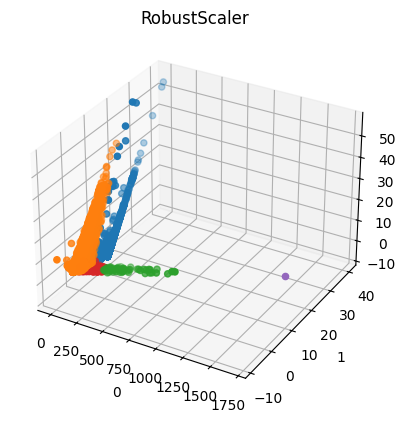

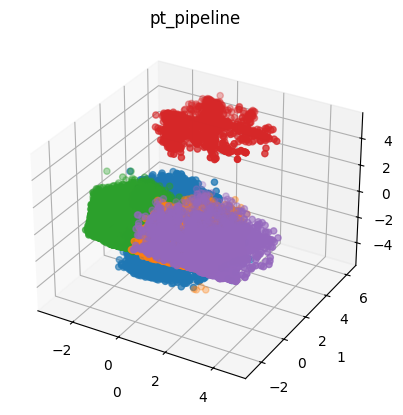

In [4]:
#plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    #plt.subplot(2, 2, i+1)
    #plt.figure()
    cluster_visualize(X, preprocess=wrap_model(scaler), pca_dims=3).set_title(scaler.__name__)
    plt.show()

# Clipping

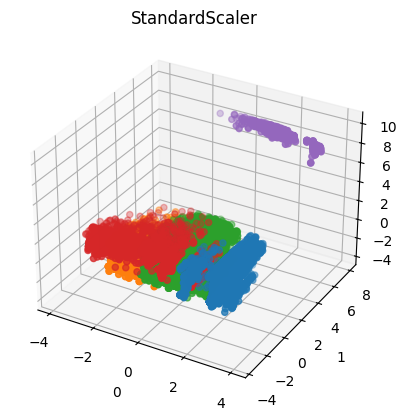

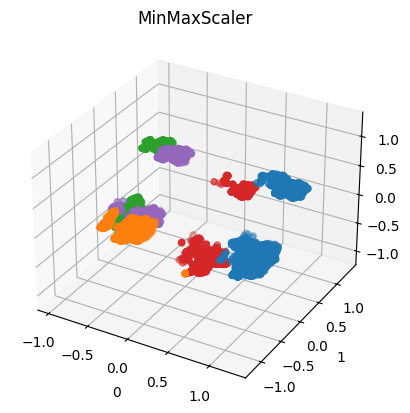

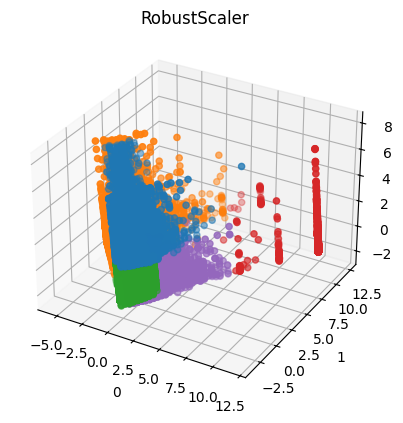

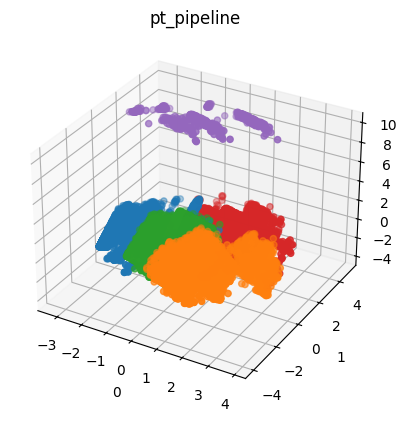

In [5]:
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

X2.reviews.replace(0, np.nan, inplace=True)
X2.price.replace(0, np.nan, inplace=True)

#plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    #plt.subplot(2, 2, i+1)
    preprocess = wrap_model(scaler)
    cluster_visualize(X2, preprocess=preprocess, pca_dims=3).set_title(scaler.__name__)
    plt.show()

## Log transform

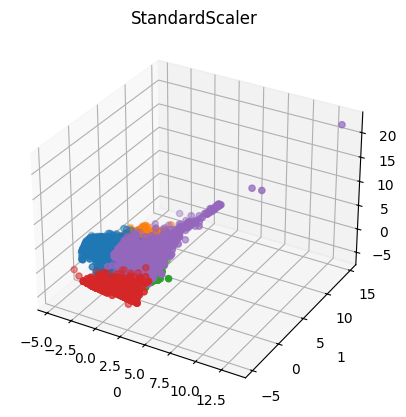

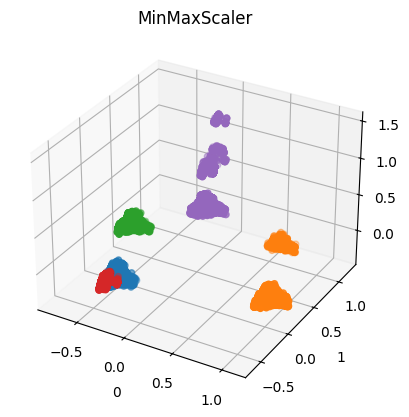

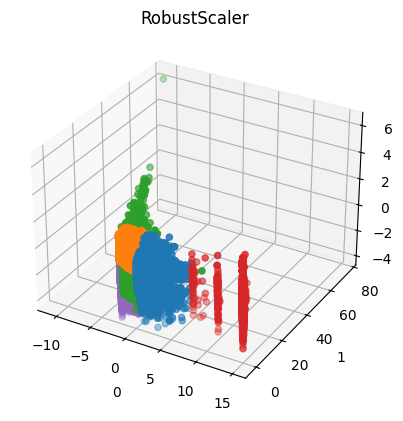

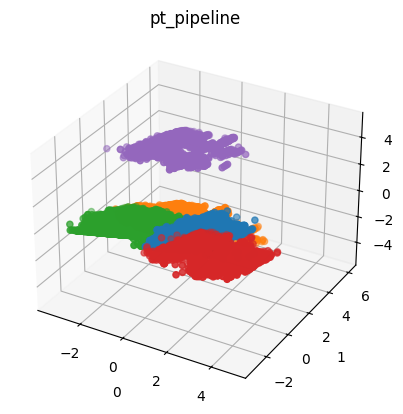

In [6]:
X2 = X.copy()
X2.reviews = np.log1p(X.reviews)
X2.price = np.log1p(X.price)
# publishedDate/stars skipped, not sure log would be applicable

#plt.figure(figsize=(12,12))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    #plt.subplot(2, 2, i+1)
    cluster_visualize(X2, preprocess=wrap_model(scaler), pca_dims=3).set_title(scaler.__name__)
    plt.show()

## Log + Clip

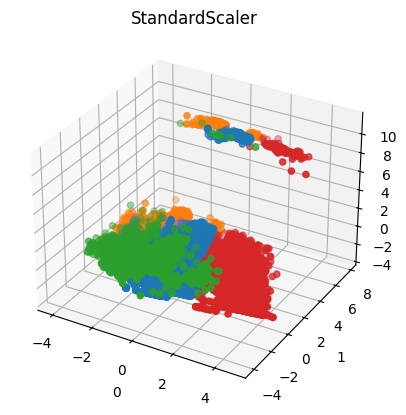

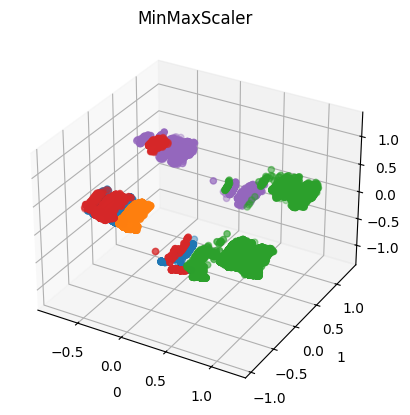

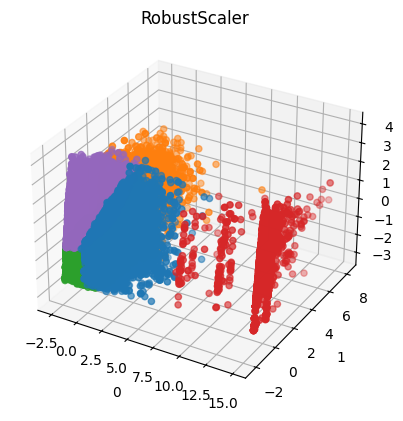

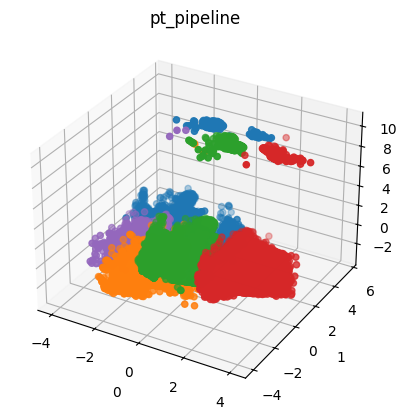

In [7]:
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

X2.reviews.replace(0, np.nan, inplace=True)
X2.price.replace(0, np.nan, inplace=True)

X2.reviews = np.log1p(X.reviews)
X2.price = np.log1p(X.price)

#plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    #plt.subplot(2, 2, i+1)
    preprocess = wrap_model(scaler)
    cluster_visualize(X2, preprocess=preprocess, pca_dims=3).set_title(scaler.__name__)
    plt.show()

In [8]:
pca = wrap_model(scaler=StandardScaler)(PCA(n_components=3)).fit(X2)
pca_out = pd.DataFrame(pca.transform(X2))
display(X2[pca_out[2] > 6].select_dtypes(bool).value_counts())
display(X2[pca_out[2] < 6].select_dtypes(bool).value_counts())

# Mostly dateClipped making a separation

isKindleUnlimited  isBestSeller  isEditorsPick  isGoodReadsChoice  reviewsClipped  priceClipped  dateClipped
False              False         False          False              False           False         True           496
                                                                                   True          True           184
                                                                   True            False         True           164
                                                                                   True          True            30
True               False         False          False              False           False         True            12
                                                                   True            False         True             7
False              True          False          False              False           False         True             5
                                                                               

isKindleUnlimited  isBestSeller  isEditorsPick  isGoodReadsChoice  reviewsClipped  priceClipped  dateClipped
False              False         False          False              False           False         False          45762
                                                                                   True          False          25360
True               False         False          False              False           False         False          22259
False              False         False          False              True            False         False          16345
True               False         False          False              True            False         False          10947
False              False         True           False              False           False         False           2533
                                                                   True            False         False           2173
                                 False          False            

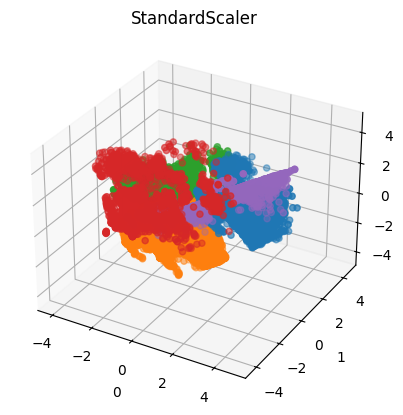

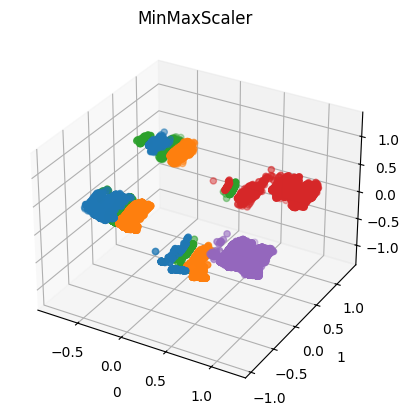

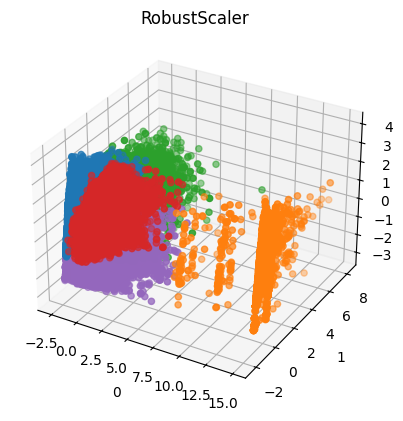

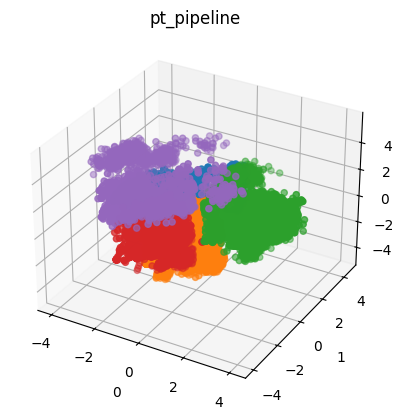

In [9]:
# Removing dateClipped to see results
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

X2.reviews.replace(0, np.nan, inplace=True)
X2.price.replace(0, np.nan, inplace=True)

X2.reviews = np.log1p(X.reviews)
X2.price = np.log1p(X.price)

#plt.figure(figsize=(12,10))
for i, scaler in enumerate([StandardScaler, MinMaxScaler, RobustScaler, pt_pipeline]):
    #plt.subplot(2, 2, i+1)
    preprocess = wrap_model(scaler)
    cluster_visualize(X2, preprocess=preprocess, pca_dims=3).set_title(scaler.__name__)
    plt.show()